In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [108]:
def get_bucket(x, bins):
        for i in range(1,len(bins)):
            if x<bins[i]:
                break
        return i - 1
        
def discretize(X, n_buckets = 10, bins = []):
    if len(bins) == 0:
        bins = np.linspace(np.min(X), np.max(X), n_buckets + 1)
    return [get_bucket(x, bins) for x in X], bins
    

(array([10010., 10038., 10053., 10232., 10061.,  9957.,  9983.,  9810.,
         9956.,  9900.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

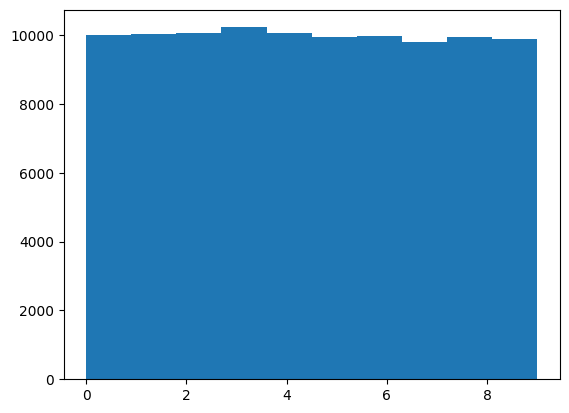

In [109]:
n = 100000
X = np.random.uniform(0,1,n)
plt.hist(discretize(X)[0])

# Criterions

### Weighing relevancy and redundancy

In [110]:
def H(X):
    return - np.sum(X * np.log(X+1e-10))

# Mutual Information
def MI(X, Y):
    data = np.transpose([X, Y])
    unique, counts = np.unique(pd.DataFrame(data), return_counts=True, axis=0)
    buckets = np.max(unique, axis=0)  + (1, 1)
    p_xy = np.zeros(buckets)
    for i in range(len(unique)):
        p_xy[unique[i][0]][unique[i][1]] = counts[i]
    p_xy /= np.sum(counts)
    p_x = np.sum(p_xy, axis=1)
    p_y = np.sum(p_xy, axis=0)
    
    return H(p_x) + H(p_y) - H(p_xy)

# Normalized Mutual Information
def NMI(X, Y):
    data = np.transpose([X, Y])
    unique, counts = np.unique(pd.DataFrame(data), return_counts=True, axis=0)
    buckets = np.max(unique, axis=0)  + (1, 1)
    p_xy = np.zeros(buckets)
    for i in range(len(unique)):
        p_xy[unique[i][0]][unique[i][1]] = counts[i]
    p_xy /= np.sum(counts)
    p_x = np.sum(p_xy, axis=1)
    p_y = np.sum(p_xy, axis=0)
    return 2 * (H(p_x) + H(p_y) - H(p_xy)) / (H(p_x) + H(p_y))

# Conditional Mutual Information
def CMI(X, Y, Z):
    CMI = 0
    for z in np.unique(Z):
        X_filtered = X[Z==z]
        Y_filtered = Y[Z==z]
        prob = np.mean(Z==z)
        mi = MI(X_filtered, Y_filtered)
        CMI += mi*prob
    return CMI

# Interaction Information
def II(X, Y, Z):
    return CMI(X, Y, Z)-MI(X, Y)

# Conditional Infomax Feature Extraction
def CIFE(Xj, Y, Xs):
    cife = MI(Xj, Y)
    for col in range(Xs.shape[1]):
        cife += II(Xj, Xs[:,col], Y)
    return cife

# Joined Mutual Information Criterion
def JMI(Xj, Y, Xs):
    jmi = MI(Xj, Y)
    S = Xs.shape[1]
    for col in range(S):
        jmi += II(Xj, Xs[:,col], Y)/S
    return jmi

# Minimum-Redundancy Maximum-Relevance Criterion
def mRMR(Xj, Y, Xs):
    mrmr = MI(Xj, Y)
    S = Xs.shape[1]
    for col in range(S):
        mrmr -= MI(Xj, Xs[:,col])/S
    return mrmr

# Conditional Mutual Information Maximization Criterion <- Min-max
def CMIM(Xj, Y, Xs):
    maximum = -np.inf
    S = Xs.shape[1]
    if S == 0:
        maximum = 0
    for col in range(S):
        gain = MI(Xj, Xs[:,col]) - CMI(Xj, Xs[:,col], Y)
        if gain > maximum:
            maximum = gain
    return MI(Xj, Y) - maximum

In [111]:
# Unit testing if methods are implemented correctly
import numpy as np
from scipy.stats import entropy
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score

np.random.seed(42)
X = np.random.randint(0, 5, size=100)
Y = np.random.randint(0, 5, size=100)
Z = np.random.randint(0, 5, size=100)
Xs = np.random.randint(0, 5, size=(100, 5))



print(f"MI test: {MI(X, Y)-mutual_info_score(X, Y)}")

# From labs with checked answers
def conditional_mutual_information(X, Y, Z):

    z_values = np.unique(Z)
    n_z_values = len(z_values)
    n = len(Z)

    cmi = 0

    for i in range(n_z_values):

        z_value_tmp = z_values[i]
        z_condition = (Z == z_value_tmp)

        X_z = X[z_condition]
        Y_z = Y[z_condition]

        mi_XY_z = mutual_info_score(X_z, Y_z)
        p_z = np.sum(z_condition)/n

        cmi += p_z*mi_XY_z

    return cmi
print(f"CMI test: {CMI(X, Y, Z)-conditional_mutual_information(X, Y, Z)}")

#From labs
def interaction_information(X, Y, Z):
    return conditional_mutual_information(X, Y, Z) - mutual_info_score(X, Y)

print(f"II test: {II(X, Y, Z)-interaction_information(X, Y, Z)}")

MI test: 1.299999413673092e-09
CMI test: 4.240000572863778e-10
II test: -8.759993841422897e-10


### Feature selection

In [112]:
n = 1000
X1 = np.random.randint(0, 5, size=n)
X2 = np.random.randint(0, 5, size=n)
X3 = np.random.randint(0, 5, size=n)
X4 = np.random.randint(0, 5, size=n)
X5 = np.random.randint(0, 5, size=n)
X6 = X3 + X1
X7 = X5 * X2
names = ["X1", "X2", "X3", "X4", "X5", "X6", "X7"]
Y = ((X7 - X2 + X6 + X1)>3).astype(int) 

criterions = [CIFE, JMI, mRMR, CMIM]

X = np.transpose([X1, X2, X3, X4, X5, X6, X7])

def FeatureSelection(X, Y, criterion = CIFE, k = 3, names = None):
    choosen_names = []
    Xs=np.array([[]])
    data_t = np.transpose(X)
    if names == None:
        names = list(range(len(data_t)))

    for _ in range(k):
        maximum = -np.inf
        i_best = 0
        for i in range(len(data_t)):
            Xj = data_t[i]
            information = criterion(Xj, Y, Xs)
            if information > maximum:
                maximum = information
                i_best = i
        Xs = np.hstack([Xs, np.transpose([data_t[i_best]])]) if len(Xs[0])>0 else np.transpose([data_t[i_best]])
        data_t = np.concatenate((data_t[:i_best], data_t[i_best+1:]))
        
        choosen_names.append(names[i_best])
        names = np.concatenate((names[:i_best], names[i_best+1:]))
    return choosen_names, Xs

FeatureSelection(X, Y, CMIM, k=4, names=["X1", "X2", "X3", "X4", "X5", "X6", "X7"])

(['X6', 'X7', 'X3', 'X1'],
 array([[ 6,  4,  4,  2],
        [ 6, 12,  4,  2],
        [ 6,  0,  3,  3],
        ...,
        [ 6,  3,  2,  4],
        [ 2,  6,  2,  0],
        [ 1,  0,  1,  0]]))

In [113]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

def OtherFeatureSelection(X, Y, k=3, names = None, n_estimators=10, max_iter=20):
    if names == None:
        names = list(range(len(X[0])))
        
    # Model
    model = RandomForestClassifier(n_estimators=100, max_depth=k, random_state=42)
    model.fit(X, Y)
    
    # Feature Importance
    FI = model.feature_importances_ 
    sorted_by_importance = np.array(names)[np.argsort(FI)[::-1]]
    fi = sorted_by_importance[:k]
    fi_X = np.transpose(np.transpose(X)[np.argsort(FI)[::-1][:k]])
    
    # Boruta
    selector = BorutaPy(
        verbose=0,
        estimator=model,
        n_estimators=n_estimators,
        max_iter=max_iter  # number of iterations to perform
    )
    selector.fit(X, Y)
    boruta = selector.transform(np.array([names]))[0]
    boruta_X = selector.transform(X)
    return fi, fi_X, boruta, boruta_X


fi, fi_X, boruta, boruta_X = OtherFeatureSelection(X, Y, k=3, names=names)
print(f"Boruta: {boruta}, Feature Importance: {fi}")


Boruta: ['X1' 'X2' 'X3' 'X5' 'X6' 'X7'], Feature Importance: ['X1' 'X7' 'X6']


In [114]:
X_test = X
def transform_test(X_test, selected_names, names):
    choosen = [i for i in range(len(names)) if names[i] in selected_names]
    return np.transpose(np.transpose(X_test)[choosen])
transform_test(X_test, fi, names)

array([[ 2,  6,  4],
       [ 2,  6, 12],
       [ 3,  6,  0],
       ...,
       [ 4,  6,  3],
       [ 0,  2,  6],
       [ 0,  1,  0]])

# Artificial examples

## Working with all methods

In [115]:
n = 1000
m = 5
X1 = np.random.randint(0, m, size=n)
X2 = np.random.randint(0, m, size=n)
X3 = np.random.randint(0, m, size=n)
X4 = np.random.randint(0, m, size=n)
X5 = np.random.randint(0, m, size=n)
X6 = np.random.randint(0, m, size=n)
X7 = np.random.randint(0, m, size=n)
X8 = (X3 + X6)//2
X9 = (X5 * X2)//(m-1)

X = np.transpose([X1, X2, X3, X4, X5, X6, X7])
names = ["X1", "X2", "X3", "X4", "X5", "X6", "X7"]


Y = ((X1 + X5 + X2)//3>=m/2).astype(int) 



criterions = [CIFE, JMI, mRMR, CMIM]
expected = ['X1', 'X2', 'X5']
print(f"Expected: {expected}")

for criterion in criterions:
    result = FeatureSelection(X, Y, criterion, k=len(expected), names=names)
    accuracy = np.mean([r in expected for r in result[0]])
    print(f"{criterion.__name__}: {result[0]}, acc = {accuracy}")

Expected: ['X1', 'X2', 'X5']
CIFE: ['X5', 'X1', 'X2'], acc = 1.0
JMI: ['X5', 'X1', 'X2'], acc = 1.0
mRMR: ['X5', 'X1', 'X2'], acc = 1.0
CMIM: ['X5', 'X1', 'X2'], acc = 1.0


### Repeat of experiments

In [116]:
n = 1000
m = 5

results = {criterion.__name__:[] for criterion in criterions}
for _ in range(100):
    X1 = np.random.randint(0, m, size=n)
    X2 = np.random.randint(0, m, size=n)
    X3 = np.random.randint(0, m, size=n)
    X4 = np.random.randint(0, m, size=n)
    X5 = np.random.randint(0, m, size=n)
    X6 = np.random.randint(0, m, size=n)
    X7 = np.random.randint(0, m, size=n)
    X8 = (X3 + X6)//2
    X9 = (X5 * X2)//(m-1)

    X = np.transpose([X1, X2, X3, X4, X5, X6, X7])
    names = ["X1", "X2", "X3", "X4", "X5", "X6", "X7"]

    Y = ((X1 + X5 + X2)//3>=m/2).astype(int) 
     
    expected = ['X1', 'X2', 'X5']
    
    for criterion in criterions:
        result = FeatureSelection(X, Y, criterion, k=len(expected), names=names)
        accuracy = np.mean([r in expected for r in result[0]])
        results[criterion.__name__].append(accuracy)
for k, v in results.items():
    print(f"{k}: {np.mean(v)}")

CIFE: 1.0
JMI: 1.0
mRMR: 1.0
CMIM: 1.0


## Not working with some methods

In [117]:
n = 1000
m = 5
X1 = np.random.randint(0, m, size=n)
X2 = np.random.randint(0, m, size=n)
X3 = np.random.randint(0, m, size=n)
X4 = np.random.randint(0, m, size=n)
X5 = np.random.randint(0, m, size=n)
X6 = np.random.randint(0, m, size=n)
X7 = np.random.randint(0, m, size=n)
X8 = np.random.randint(0, m, size=n)
X9 = (X7==X5).astype(int)*(-X7)

X = np.transpose([X1, X2, X3, X4, X5, X6, X7])
names = ["X1", "X2", "X3", "X4", "X5", "X6", "X7"]

Y = X5+X9+X8
Y = (Y>=np.mean(Y)).astype(int) 



criterions = [CIFE, JMI, mRMR, CMIM]
expected = ['X5', 'X7']
print(f"Expected: {expected}")

for criterion in criterions:
    result = FeatureSelection(X, Y, criterion, k=len(expected), names=names)
    accuracy = np.mean([r in expected for r in result[0]])
    print(f"{criterion.__name__}: {result[0]}, acc = {accuracy}")

Expected: ['X5', 'X7']
CIFE: ['X5', 'X7'], acc = 1.0
JMI: ['X5', 'X7'], acc = 1.0
mRMR: ['X5', 'X7'], acc = 1.0
CMIM: ['X5', 'X7'], acc = 1.0


### Repeat of experiments

In [118]:
n = 1000
m = 5

results = {criterion.__name__:[] for criterion in criterions}
for _ in range(100):
    X1 = np.random.randint(0, m, size=n)
    X2 = np.random.randint(0, m, size=n)
    X3 = np.random.randint(0, m, size=n)
    X4 = np.random.randint(0, m, size=n)
    X5 = np.random.randint(0, m, size=n)
    X6 = np.random.randint(0, m, size=n)
    X7 = np.random.randint(0, m, size=n)
    X8 = np.random.randint(0, m, size=n)
    X9 = (X7==X5).astype(int)*(-X7)

    X = np.transpose([X1, X2, X3, X4, X5, X6, X7])
    names = ["X1", "X2", "X3", "X4", "X5", "X6", "X7"]

    Y = X5+X9+X8
    Y = (Y>=np.mean(Y)).astype(int) 
    
    criterions = [CIFE, JMI, mRMR, CMIM]
    expected = ['X5', 'X7']

    for criterion in criterions:
        result = FeatureSelection(X, Y, criterion, k=len(expected), names=names)
        accuracy = np.mean([r in expected for r in result[0]])
        results[criterion.__name__].append(accuracy)
for k, v in results.items():
    print(f"{k}: {np.mean(v)}")

CIFE: 1.0
JMI: 1.0
mRMR: 0.845
CMIM: 1.0


# Real world examples

### LC- Lung Cancer
This data was used by Hong and Young to illustrate the power of the optimal discriminant plane even in ill-posed settings. Applying the KNN method in the resulting plane gave 77% accuracy. However, these results are strongly biased (See Aeberhard's second ref. above, or email to stefan@coral.cs.jcu.edu.au). Results obtained by Aeberhard et al. are :
 
RDA : 62.5%, KNN 53.1%, Opt. Disc. Plane 59.4%

The data described 3 types of pathological lung cancers. The Authors give no information on the individual variables nor on where the data was originally used.
### WDBC- Breast Cancer Wisconsin (Diagnostic)
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.  They describe characteristics of the cell nuclei present in the image. A few of the images can be found at http://www.cs.wisc.edu/~street/images/

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree.  Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].
### MI- Myocardial infarction complications
Problems of real-life complexity are needed to test and compare various data mining and pattern recognition methods. The proposed database can be used to solve two practically important problems: predicting complications of Myocardial Infarction (MI) based on information about the patient (i) at the time of admission and (ii) on the third day of the hospital period. Another important group of tasks is phenotyping of disease (cluster analysis), dynamic phenotyping (filament extraction and identification of disease trajectories) and visualisation (disease mapping). 
MI is one of the most challenging problems of modern medicine. Acute myocardial infarction is associated with high mortality in the first year after it. The incidence of MI remains high in all countries. This is especially true for the urban population of highly developed countries, which is exposed to chronic stress factors, irregular and not always balanced nutrition. In the United States, for example, more than a million people suffer from MI every year, and 200-300 thousand of them die from acute MI before arriving at the hospital. 
The course of the disease in patients with MI is different. MI can occur without complications or with complications that do not worsen the long-term prognosis. At the same time, about half of patients in the acute and subacute periods have complications that lead to worsening of the disease and even death. Even an experienced specialist can not always foresee the development of these complications. In this regard, predicting complications of myocardial infarction in order to timely carry out the necessary preventive measures is an important task. 

In [119]:
lc = pd.read_csv('C:/Users/Maciek/Documents/Studia/semestr 10/Statistical Methods in Biology/data/lung-cancer.data', header=None)
wdbc = pd.read_csv('C:/Users/Maciek/Documents/Studia/semestr 10/Statistical Methods in Biology/data/wdbc.data', header=None)
mi = pd.read_csv('C:/Users/Maciek/Documents/Studia/semestr 10/Statistical Methods in Biology/data/MI.data', header=None)


# clean up
lc = lc.replace("?", -1)
lc_y = lc.iloc[:,0]
lc_x = lc.iloc[:,1:].astype(float)
print(f"Lung cancer: {lc_x.shape}")

wdbc.iloc[:,1] = (wdbc.iloc[:,1]=="M").values.astype(int)
wdbc_y = wdbc.iloc[:,1].values
wdbc_x = wdbc.iloc[:,2:].astype(float)
print(f"Breast cancer: {wdbc_x.shape}")

mi = mi.replace("?", -1)
mi_y = mi.iloc[:,115]
mi_x = mi.iloc[:,1:111].astype(float)
print(f"Breast cancer: {mi_x.shape}")

# bucketing
def bucket_continous_variables(X, n_buckets=10):
    bins = {}
    for col in range(X.shape[1]):
        n_unique =  len(np.unique(X.iloc[:,col]))
        if n_unique>n_buckets:
            X.iloc[:,col], bins[col] = discretize(X.iloc[:,col], n_buckets)
        else:
            X.iloc[:,col], bins[col] = discretize(X.iloc[:,col], n_unique)
    return bins

def bucket_test_data(X, bins):
    for col in bins.keys():
        X.iloc[:,col] = discretize(X.iloc[:,col], 0, bins[col])[0]
    return X
    


Lung cancer: (32, 56)
Breast cancer: (569, 30)
Breast cancer: (1700, 110)


### Implemented models

In [121]:
from sklearn.metrics import accuracy_score
np.random.seed(123)

n_experiments = 15
criterions = [CIFE, JMI, mRMR, CMIM]
n_buckets = 10           
final_results = pd.DataFrame()
for data in [(mi_x, mi_y.values, "mi"), (wdbc_x, wdbc_y, "wdbc"), (lc_x, lc_y, "lc")]:
    for k in range(2,20,2):
        results = {}
        for criterion in criterions:
            results_crit = []
            for _ in range(n_experiments):
                # Train test split + bucketing
                X_train, X_test, y_train, y_test = train_test_split(data[0], data[1])
                X_bins = bucket_continous_variables(X_train, n_buckets)
                
                # Feature selection
                result = FeatureSelection(X_train.values.astype(int), y_train.astype(int), criterion, k=k)
                result = np.array(result[0]).astype(int)
                X_choosen = np.transpose(np.transpose(X_train.values)[result])
                
                # Model
                model = RandomForestClassifier(n_estimators=k*20, max_depth=k)
                model.fit(X_choosen, y_train.astype(int))
                X_test = bucket_test_data(X_test, X_bins)
                X_choosen_test = np.transpose(np.transpose(X_test.values)[result])
                y_pred = model.predict(X_choosen_test.astype(int))
                
                # Results
                results_crit.append(accuracy_score(y_pred.astype(int), y_test.astype(int)))
                
            results[criterion.__name__] = results_crit
            
        results_boruta = []
        results_fi = []
        boruta_problem_flag = 0
        boruta_clusters = []
        for _ in range(n_experiments):

            # Train test split + bucketing
            X_train, X_test, y_train, y_test = train_test_split(data[0], data[1])
            X_bins = bucket_continous_variables(X_train, n_buckets)

            # Feature selection
            if boruta_problem_flag == 0:
                fi, fi_X, boruta, boruta_X = OtherFeatureSelection(X_train.values.astype(int), y_train.astype(int), k=k, n_estimators=k*10, max_iter=k*20)
            else:
                fi, fi_X, boruta, boruta_X = OtherFeatureSelection(X_train.values.astype(int), y_train.astype(int), k=k, n_estimators=k*15, max_iter=k*25)
                
            if len(boruta)==0:
                boruta_problem_flag = 1
            
            X_boruta = np.transpose(np.transpose(X_train.values)[boruta])
            X_fi = np.transpose(np.transpose(X_train.values)[fi])
            boruta_clusters.append(len(boruta))

            # Model
            if len(boruta)==0:
                results_boruta.append(0)
            else:
                model_boruta = RandomForestClassifier(n_estimators=k*20, max_depth=k)
                model_boruta.fit(X_boruta, y_train.astype(int))
                X_test = bucket_test_data(X_test, X_bins)
                X_boruta_test = np.transpose(np.transpose(X_test.values)[boruta])
                y_pred_boruta = model_boruta.predict(X_boruta_test.astype(int))
                results_boruta.append(accuracy_score(y_pred_boruta.astype(int), y_test.astype(int)))

            model_fi = RandomForestClassifier(n_estimators=k*20, max_depth=k)
            model_fi.fit(X_fi, y_train.astype(int))
            X_test = bucket_test_data(X_test, X_bins)
            X_fi_test = np.transpose(np.transpose(X_test.values)[fi])
            y_pred_fi = model_fi.predict(X_fi_test.astype(int))
            results_fi.append(accuracy_score(y_pred_fi.astype(int), y_test.astype(int)))
            
        combined_results = pd.DataFrame(results)
        combined_results["feature_importance"] = results_fi
        combined_results["boruta"] = results_boruta
        combined_results["n_clusters"] = k
        combined_results["boruta_clusters"] = boruta_clusters
        combined_results["data"] = data[2]
        final_results = pd.concat([final_results, combined_results])

final_results

CIFE       JMI      mRMR      CMIM  feature_importance    boruta  \
0   0.962353  0.964706  0.957647  0.952941            0.964706  0.964706   
1   0.948235  0.962353  0.967059  0.957647            0.962353  0.962353   
2   0.962353  0.948235  0.962353  0.960000            0.101176  0.957647   
3   0.955294  0.955294  0.955294  0.948235            0.960000  0.960000   
4   0.962353  0.960000  0.948235  0.950588            0.080000  0.971765   
..       ...       ...       ...       ...                 ...       ...   
10  0.500000  0.500000  0.375000  0.375000            0.250000  0.500000   
11  0.125000  0.750000  0.750000  0.375000            0.375000  0.625000   
12  0.500000  0.375000  0.500000  0.750000            0.500000  0.500000   
13  0.250000  0.625000  0.500000  0.625000            0.375000  0.250000   
14  0.375000  0.250000  0.750000  0.375000            0.500000  0.875000   

    n_clusters  boruta_clusters data  
0            2                2   mi  
1            2                1   mi  
2            2                2   mi  
3            2                1   mi  
4            2                2   mi  
..         ...              ...  ...  
10          18                2   lc  
11          18                5   lc  
12          18                5   lc  
13          18                1   lc  
14          18                2   lc  

[405 rows x 9 columns]

## Results analysis

In [122]:
final_results2 = final_results
final_results2.to_csv("final_results2.csv")
final_results2

CIFE       JMI      mRMR      CMIM  feature_importance    boruta  \
0   0.962353  0.964706  0.957647  0.952941            0.964706  0.964706   
1   0.948235  0.962353  0.967059  0.957647            0.962353  0.962353   
2   0.962353  0.948235  0.962353  0.960000            0.101176  0.957647   
3   0.955294  0.955294  0.955294  0.948235            0.960000  0.960000   
4   0.962353  0.960000  0.948235  0.950588            0.080000  0.971765   
..       ...       ...       ...       ...                 ...       ...   
10  0.500000  0.500000  0.375000  0.375000            0.250000  0.500000   
11  0.125000  0.750000  0.750000  0.375000            0.375000  0.625000   
12  0.500000  0.375000  0.500000  0.750000            0.500000  0.500000   
13  0.250000  0.625000  0.500000  0.625000            0.375000  0.250000   
14  0.375000  0.250000  0.750000  0.375000            0.500000  0.875000   

    n_clusters  boruta_clusters data  
0            2                2   mi  
1            2                1   mi  
2            2                2   mi  
3            2                1   mi  
4            2                2   mi  
..         ...              ...  ...  
10          18                2   lc  
11          18                5   lc  
12          18                5   lc  
13          18                1   lc  
14          18                2   lc  

[405 rows x 9 columns]

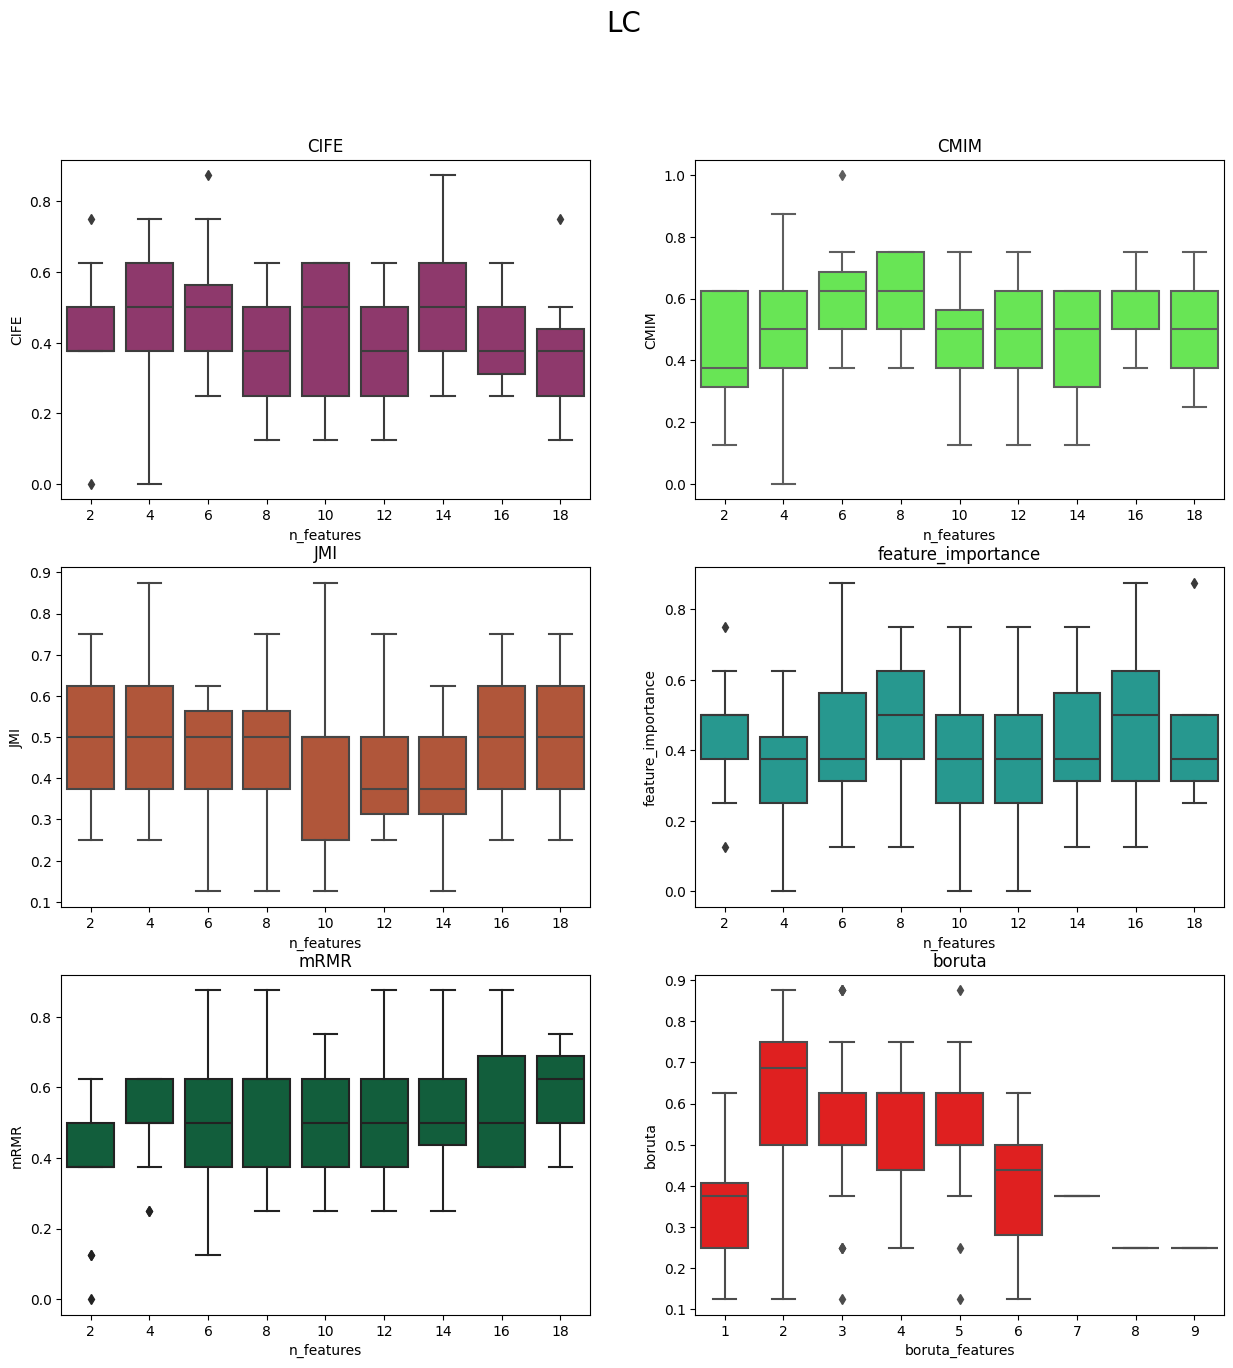

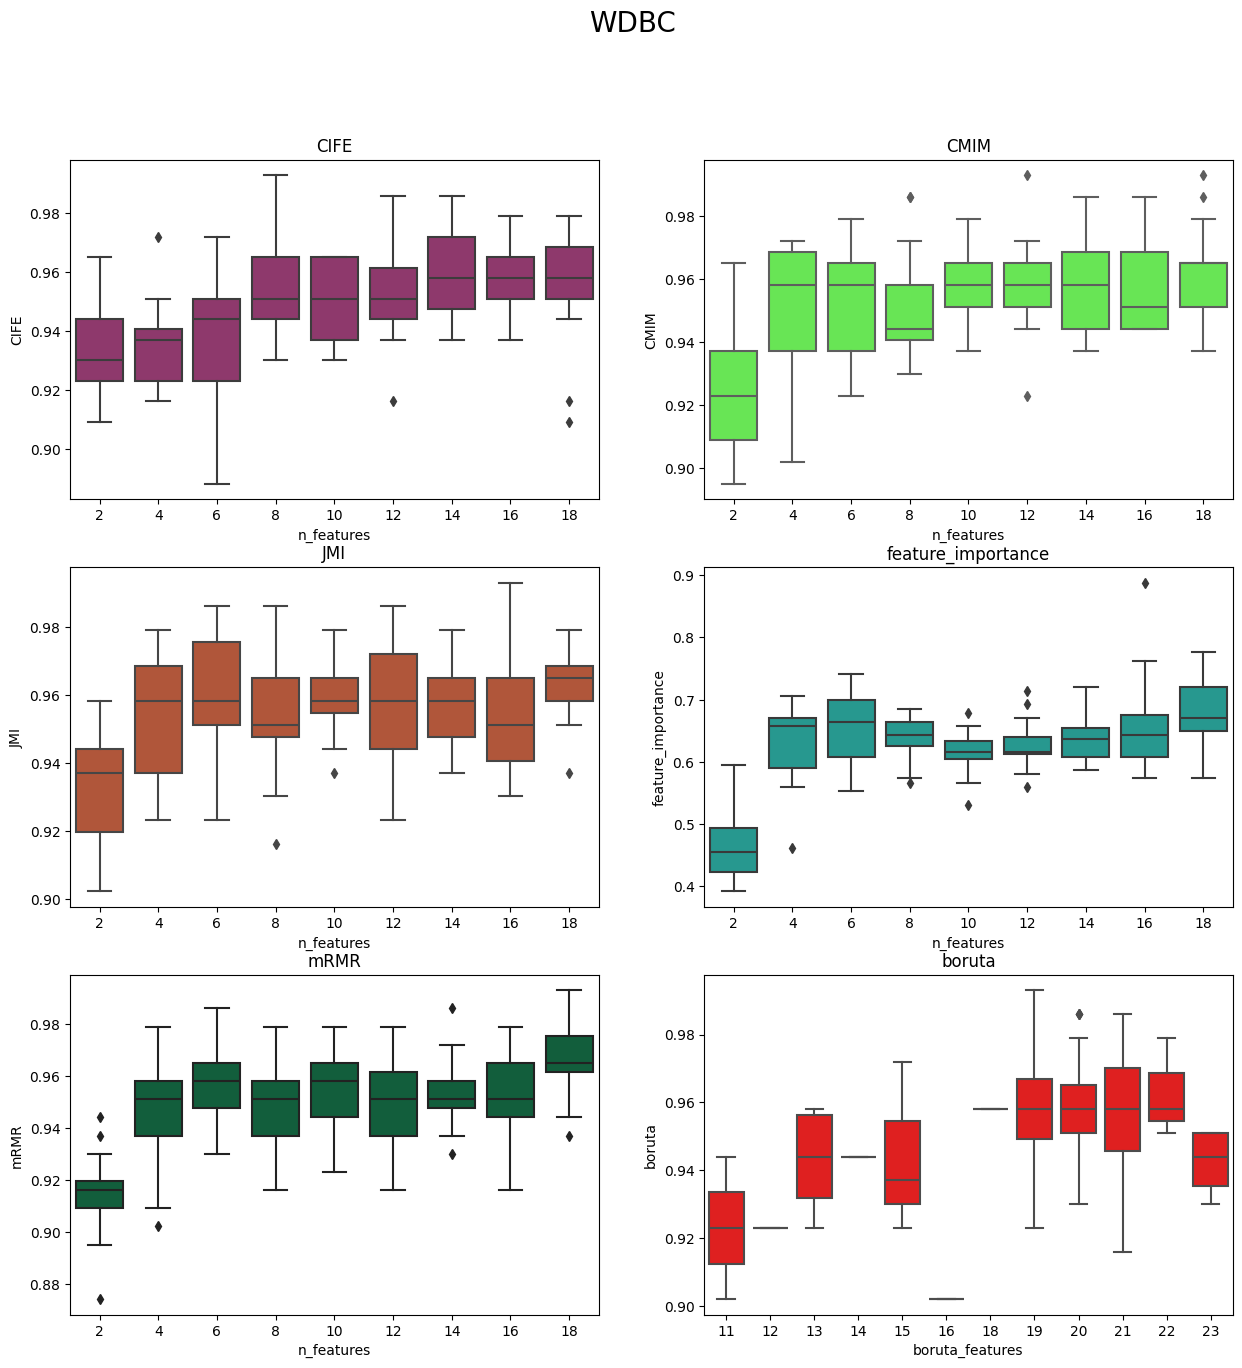

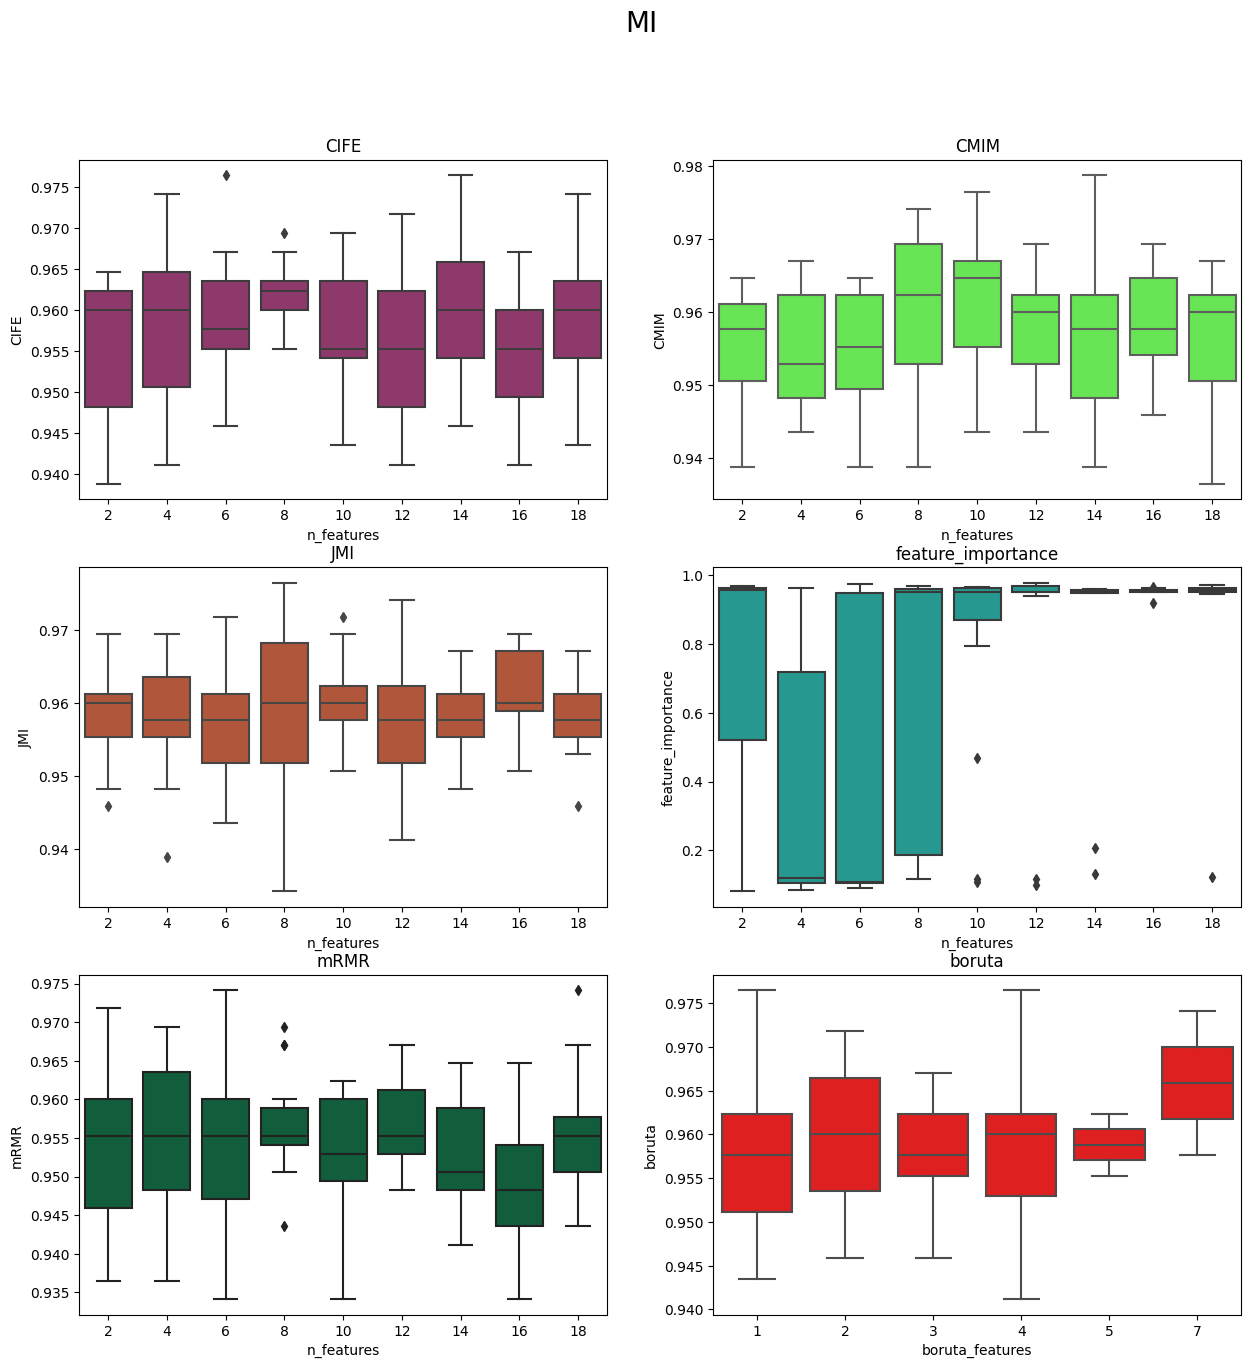

In [123]:
import seaborn as sns

final_results["n_features"] = final_results["n_clusters"]
final_results["boruta_features"] = final_results["boruta_clusters"]

for dataset in ["lc", "wdbc", "mi"]:
    f, ax = plt.subplots(3,2)
    f.set_figheight(15)
    f.set_figwidth(15)
    i=j=0
    np.random.seed(111)
    for method in ["CIFE", "JMI", "mRMR", "CMIM", "feature_importance"]:
        sns.boxplot(data=final_results[final_results.data==dataset], y=method, x="n_features", color=np.random.uniform(0,1,3), ax=ax[i,j])
        ax[i,j].set_title(method)
        i += 1
        if i>2:
            i=0
            j+=1
    boruta_data = final_results[final_results.boruta_clusters>0]
    sns.boxplot(data=boruta_data[boruta_data.data==dataset], y="boruta", x="boruta_features", color="red", ax=ax[i,j])
    ax[i,j].set_title("boruta")
    f.suptitle(dataset.upper(),fontsize=20 )
    plt.show()

# SVM

In [124]:
from sklearn.svm import SVC
np.random.seed(123)

n_experiments = 15 #To save some time we will run each experiment only 15 times
criterions = [CIFE, JMI, mRMR, CMIM]
n_buckets = 10           
final_results_svm = pd.DataFrame()
for data in [(mi_x, mi_y.values, "mi"), (wdbc_x, wdbc_y, "wdbc"), (lc_x, lc_y, "lc")]:
    for k in range(2,20,2):
        results = {}
        for criterion in criterions:
            results_crit = []
            for _ in range(n_experiments):
                # Train test split + bucketing
                X_train, X_test, y_train, y_test = train_test_split(data[0], data[1])
                X_bins = bucket_continous_variables(X_train, n_buckets)
                
                # Feature selection
                result = FeatureSelection(X_train.values.astype(int), y_train.astype(int), criterion, k=k)
                result = np.array(result[0]).astype(int)
                X_choosen = np.transpose(np.transpose(X_train.values)[result])
                
                # Model
                model = SVC(random_state=42, C=100, gamma='auto', kernel='rbf')
                model.fit(X_choosen, y_train.astype(int))
                X_test = bucket_test_data(X_test, X_bins)
                X_choosen_test = np.transpose(np.transpose(X_test.values)[result])
                y_pred = model.predict(X_choosen_test.astype(int))
                
                # Results
                results_crit.append(accuracy_score(y_pred.astype(int), y_test.astype(int)))
                
            results[criterion.__name__] = results_crit
            
        results_boruta = []
        results_fi = []
        boruta_problem_flag = 0
        boruta_clusters = []
        for _ in range(n_experiments):

            # Train test split + bucketing
            X_train, X_test, y_train, y_test = train_test_split(data[0], data[1])
            X_bins = bucket_continous_variables(X_train, n_buckets)

            # Feature selection
            if boruta_problem_flag == 0:
                fi, fi_X, boruta, boruta_X = OtherFeatureSelection(X_train.values.astype(int), y_train.astype(int), k=k, n_estimators=k*10, max_iter=k*20)
            else:
                fi, fi_X, boruta, boruta_X = OtherFeatureSelection(X_train.values.astype(int), y_train.astype(int), k=k, n_estimators=k*15, max_iter=k*25)
                
            if len(boruta)==0:
                boruta_problem_flag = 1
            
            X_boruta = np.transpose(np.transpose(X_train.values)[boruta])
            X_fi = np.transpose(np.transpose(X_train.values)[fi])
            boruta_clusters.append(len(boruta))

            # Model
            if len(boruta)==0:
                results_boruta.append(0)
            else:
                model_boruta = SVC(random_state=42, C=100, gamma='auto', kernel='rbf')
                model_boruta.fit(X_boruta, y_train.astype(int))
                X_test = bucket_test_data(X_test, X_bins)
                X_boruta_test = np.transpose(np.transpose(X_test.values)[boruta])
                y_pred_boruta = model_boruta.predict(X_boruta_test.astype(int))
                results_boruta.append(accuracy_score(y_pred_boruta.astype(int), y_test.astype(int)))

            model_fi = SVC(random_state=42, C=100, gamma='auto', kernel='rbf')
            model_fi.fit(X_fi, y_train.astype(int))
            X_test = bucket_test_data(X_test, X_bins)
            X_fi_test = np.transpose(np.transpose(X_test.values)[fi])
            y_pred_fi = model_fi.predict(X_fi_test.astype(int))
            results_fi.append(accuracy_score(y_pred_fi.astype(int), y_test.astype(int)))
            
        combined_results = pd.DataFrame(results)
        combined_results["feature_importance"] = results_fi
        combined_results["boruta"] = results_boruta
        combined_results["n_clusters"] = k
        combined_results["boruta_clusters"] = boruta_clusters
        combined_results["data"] = data[2]
        final_results_svm = pd.concat([final_results_svm, combined_results])

final_results_svm

CIFE       JMI      mRMR      CMIM  feature_importance    boruta  \
0   0.962353  0.960000  0.948235  0.960000            0.974118  0.974118   
1   0.957647  0.962353  0.967059  0.948235            0.967059  0.967059   
2   0.952941  0.955294  0.964706  0.964706            0.976471  0.976471   
3   0.960000  0.952941  0.967059  0.950588            0.960000  0.960000   
4   0.952941  0.941176  0.962353  0.962353            0.964706  0.964706   
..       ...       ...       ...       ...                 ...       ...   
10  0.375000  0.625000  0.500000  0.375000            0.375000  0.625000   
11  0.375000  0.125000  0.375000  0.375000            0.375000  0.250000   
12  0.250000  0.500000  0.250000  0.500000            0.500000  0.750000   
13  0.750000  0.375000  0.500000  0.375000            0.250000  0.375000   
14  0.375000  0.500000  0.875000  0.500000            0.250000  0.500000   

    n_clusters  boruta_clusters data  
0            2                1   mi  
1            2                2   mi  
2            2                3   mi  
3            2                3   mi  
4            2                1   mi  
..         ...              ...  ...  
10          18                6   lc  
11          18                6   lc  
12          18                4   lc  
13          18                7   lc  
14          18                4   lc  

[405 rows x 9 columns]

In [125]:
final_results_svm2 = final_results_svm
final_results_svm2.to_csv("final_results_svm2.csv")

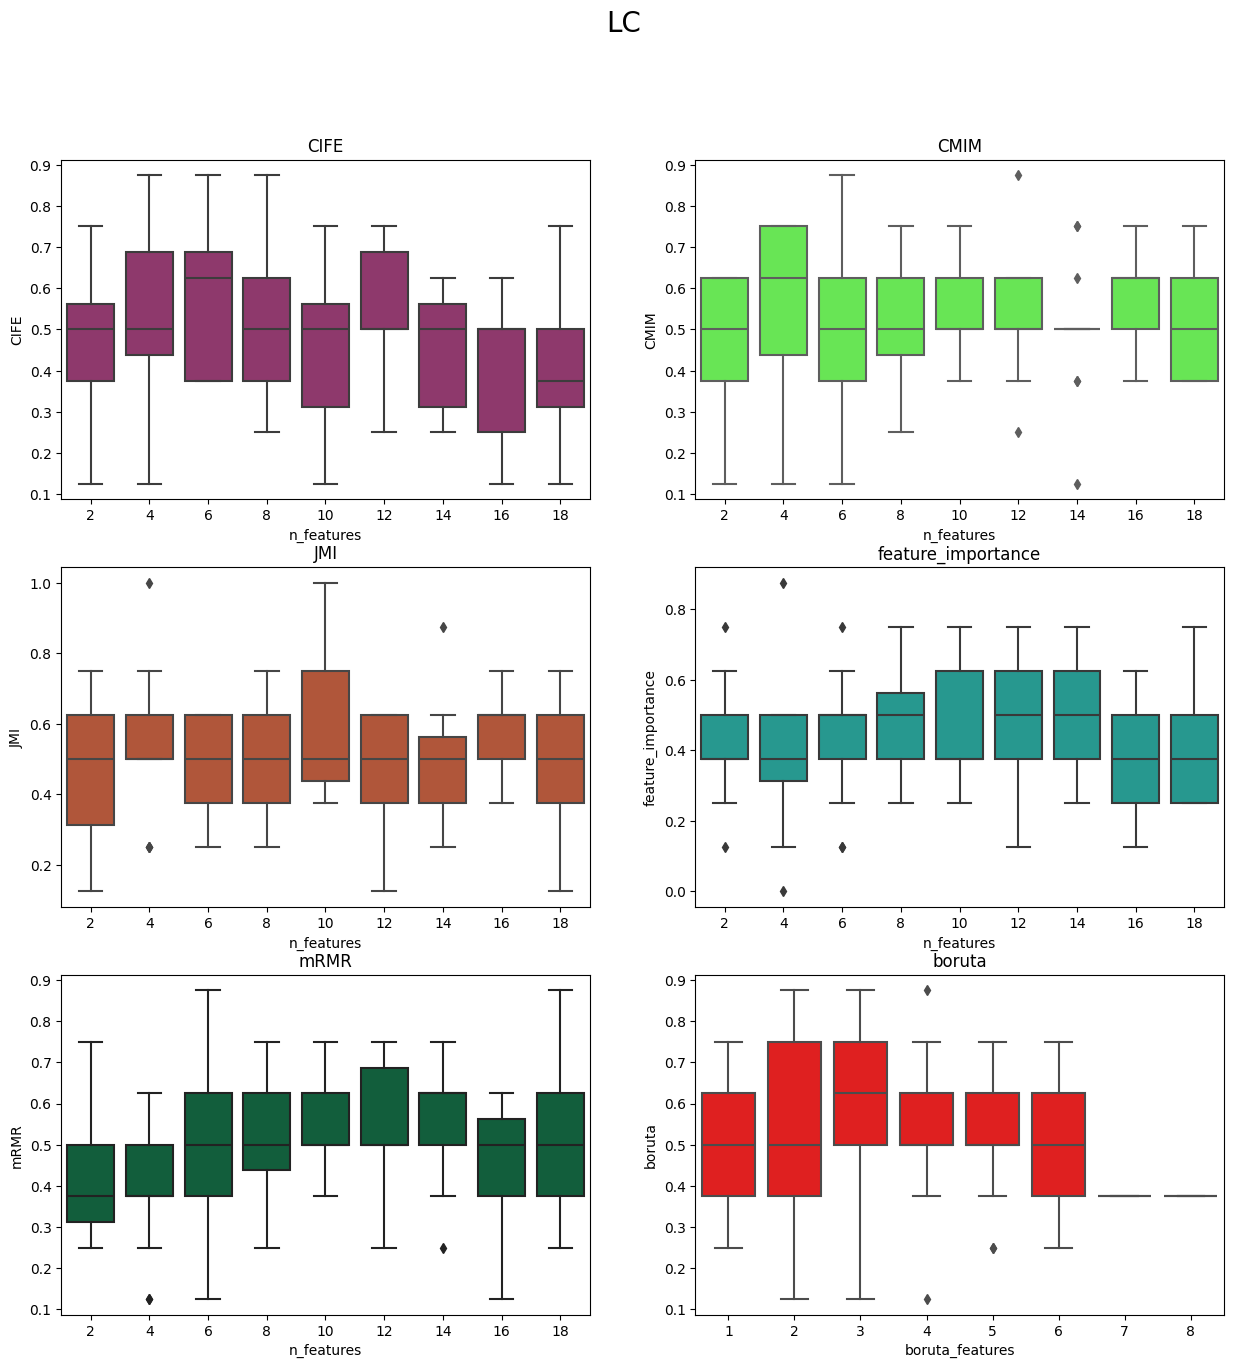

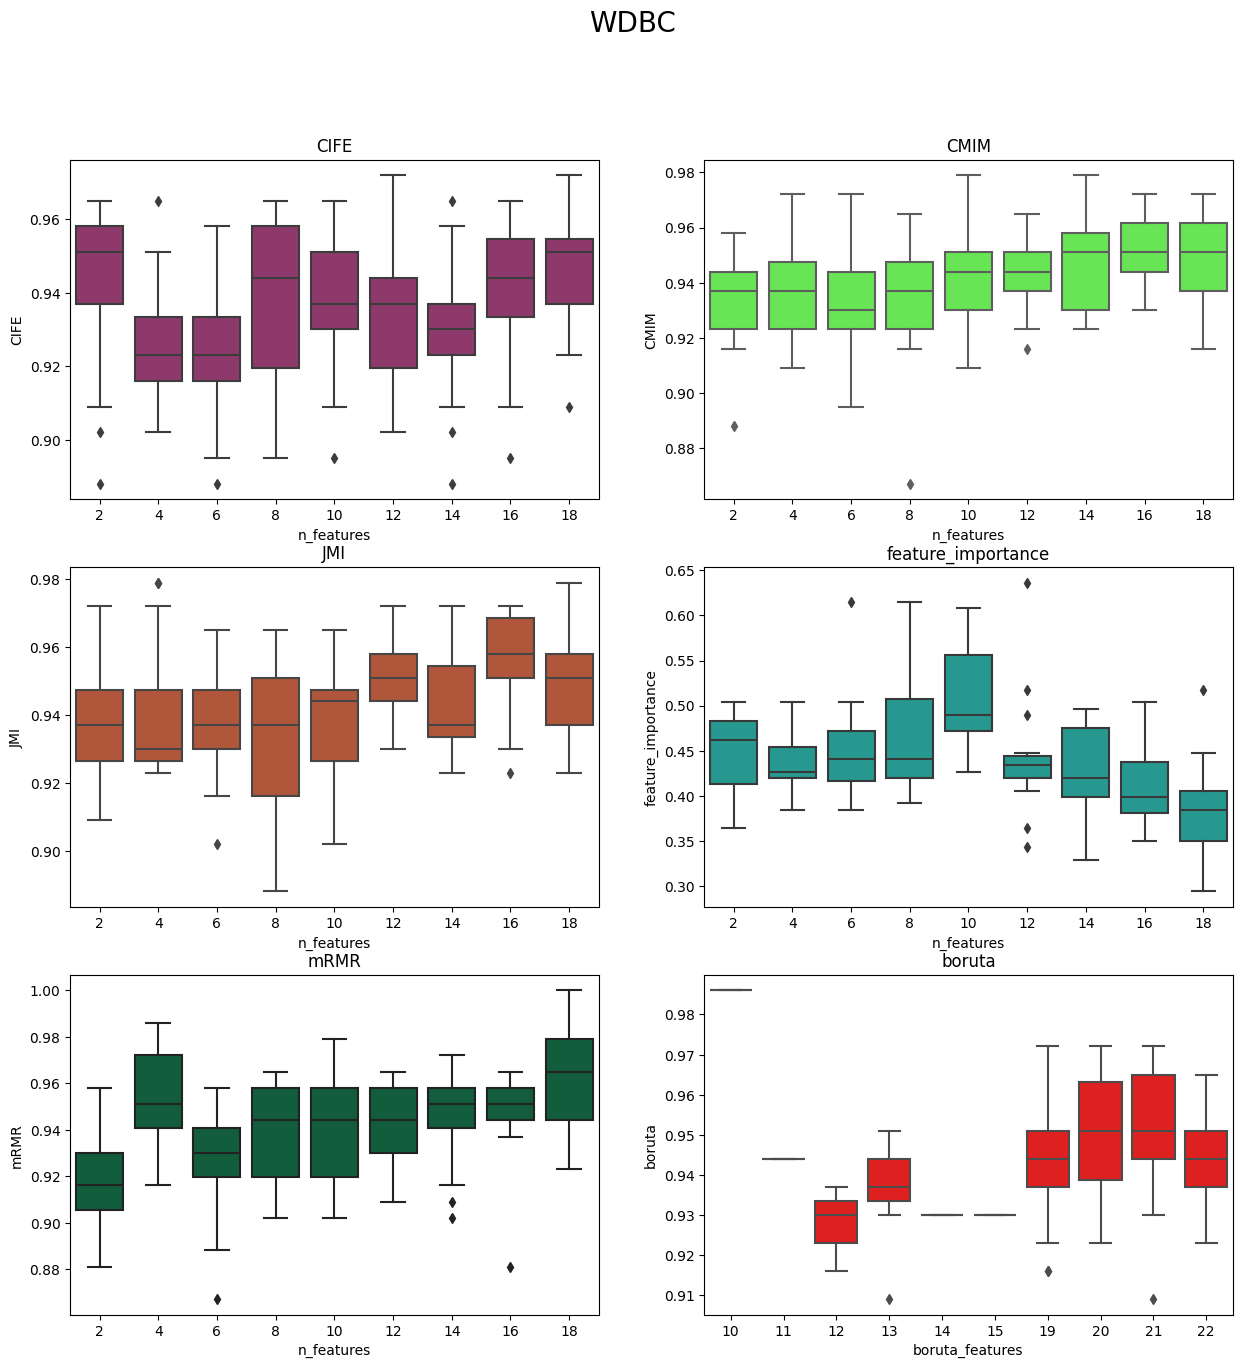

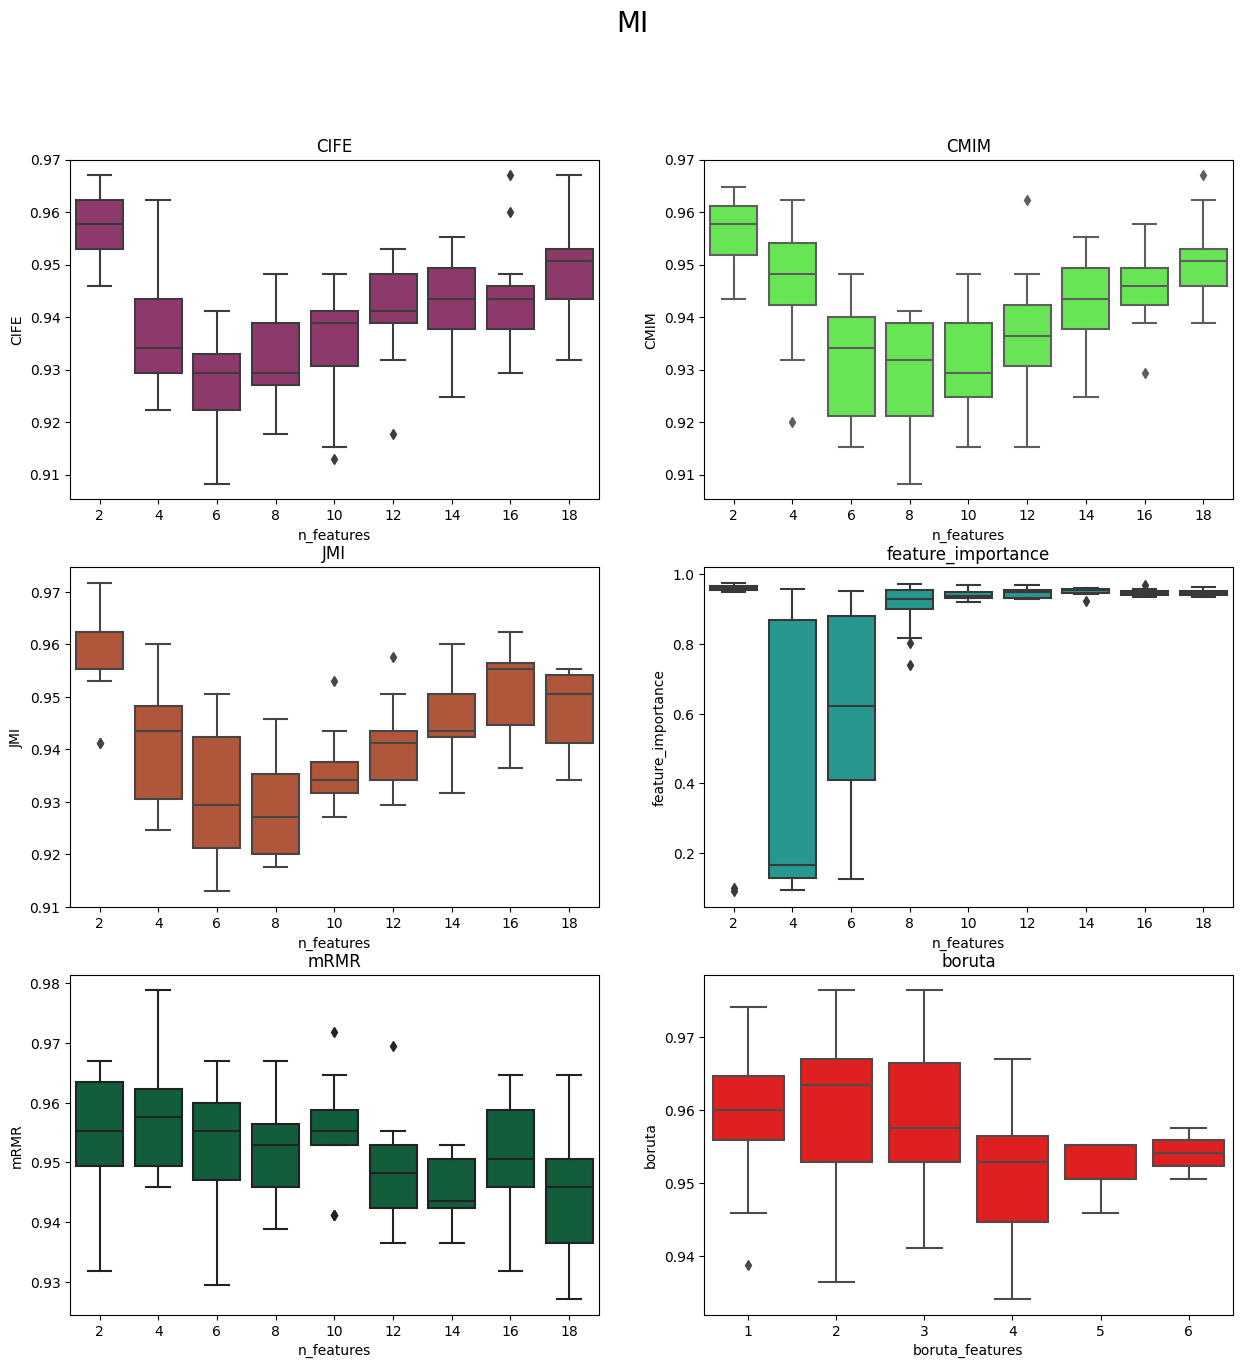

In [126]:
import seaborn as sns
final_results_svm["n_features"] = final_results_svm["n_clusters"]
final_results_svm["boruta_features"] = final_results_svm["boruta_clusters"]

for dataset in ["lc", "wdbc", "mi"]:
    f, ax = plt.subplots(3,2)
    f.set_figheight(15)
    f.set_figwidth(15)
    i=j=0
    np.random.seed(111)
    for method in ["CIFE", "JMI", "mRMR", "CMIM", "feature_importance"]:
        sns.boxplot(data=final_results_svm[final_results_svm.data==dataset], y=method, x="n_features", color=np.random.uniform(0,1,3), ax=ax[i,j])
        ax[i,j].set_title(method)
        i += 1
        if i>2:
            i=0
            j+=1

    boruta_data = final_results_svm[final_results_svm.boruta_clusters>0]
    sns.boxplot(data=boruta_data[boruta_data.data==dataset], y="boruta", x="boruta_features", color="red", ax=ax[i,j])
    ax[i,j].set_title("boruta")
    f.suptitle(dataset.upper(),fontsize=20 )
    plt.show()